**LOAD LIBRARIES**

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import re
import json
import seaborn as sns
import tweepy as tp
import requests
import io
#import twitter_credentials

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from pandas.plotting import scatter_matrix

from IPython.display import display, HTML, Image

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# 3.0 Feature Engineering

This EDA Notebook focuses User Level Analysis, as well on understanding the relevancy of NPL Features engineered with Azure API.


### 3.1 READ TWEETS FROM JSON FILES

In [3]:
try:
    #with open('tweet_master.json') as json_file:  
    with open('final_tweets_master_withNLP.json') as json_file:  
        tweet_json = json.load(json_file)

    #with open('tweet_master.json') as json_file:  
    with open('more_final_tweets_master_withNLP.json') as json_file:  
        tweet_json_more = json.load(json_file)

except Exception as e:
    print("Loading Data from Azure - data files do not exist locally")
    
    final_url = "https://eumarharvardfiles.blob.core.windows.net/cscis109/final_tweets_master_withNLP.json"
    fina_content = requests.get(final_url).content

    more_url = "https://eumarharvardfiles.blob.core.windows.net/cscis109/more_final_tweets_master_withNLP.json"
    more_content = requests.get(more_url).content

    tweet_json = json.load(io.StringIO(fina_content.decode('utf-8')))
    tweet_json_more =json.load(io.StringIO(more_content.decode('utf-8')))
    
tweet_df_first = pd.read_json(tweet_json)
tweet_df_more = pd.read_json(tweet_json_more)

print(tweet_df_first.shape, tweet_df_more.shape)

Loading Data from Azure - does not exist locally
(51106, 30) (14801, 30)


In [4]:
print(tweet_df_first.groupby('TypeOfUser').size())
print(tweet_df_more.groupby('TypeOfUser').size())

TypeOfUser
Bot         42903
Unknown      4977
Verified     3226
dtype: int64
TypeOfUser
Unknown       645
Verified    14156
dtype: int64


In [5]:
# Combine files into Tweet Df
tweet_df = tweet_df_first.append(tweet_df_more,ignore_index = True)
tweet_df.reset_index(drop=True, inplace=True)

print (tweet_df.shape)
print(tweet_df.groupby('TypeOfUser').size())

(65907, 30)
TypeOfUser
Bot         42903
Unknown      5622
Verified    17382
dtype: int64


**ADD DATE & TIME COLUMNS**

In [6]:
tweet_df['year'] = pd.to_datetime(tweet_df['created_at']).apply(lambda x: x.year)

tweet_df['month'] = pd.to_datetime(tweet_df['created_at']).apply(lambda x: x.month)

tweet_df['day'] = pd.to_datetime(tweet_df['created_at']).apply(lambda x: x.day)

tweet_df['hour'] = pd.to_datetime(tweet_df['created_at']).apply(lambda x: x.hour)

tweet_df['minute'] = pd.to_datetime(tweet_df['created_at']).apply(lambda x: x.minute)

tweet_df['second'] = pd.to_datetime(tweet_df['created_at']).apply(lambda x: x.second)

tweet_df['minute_of_day'] = tweet_df['hour']*60+tweet_df['minute']

tweet_df['is_bot'] = tweet_df['TypeOfUser'].apply(lambda x: 1 if x == 'Bot' else 0)

print( "Tweets before cleaning null date - {0}".format(tweet_df.shape) )

tweet_df = tweet_df.loc[pd.notnull(tweet_df['minute'])]

print( "Tweets after cleaning null date - {0}".format(tweet_df.shape) )


Tweets before cleaning null date - (65907, 38)
Tweets after cleaning null date - (65558, 38)


### 3.2 Group Tweets by user and generate user level features

In [8]:
def calculate_avg_delta (x):
    '''Function to calculate average intertweet time for each user.'''

    x_sorted = np.sort(x)
    
    total_items = len(x)
    
    if total_items == 1:
        return 24 * 60; # return one day

    list_deltas = np.zeros(total_items)
    one_hour_delta = np.timedelta64(1, 'h')
       
    for (i, item) in enumerate(x_sorted):
        if i != (total_items - 1):
            
            d1 = item
            d2 = x_sorted[i + 1]
            
            list_deltas[i] = (d2-d1) / one_hour_delta
            
            
    return np.std(list_deltas)

def calculate_avg_tweet_length (x):
    '''Function to calculate average tweets text size for each user.'''
   
    list_deltas = [len(item) for item in x]
       
    return np.mean(list_deltas)

tweet_df_grouped_user = tweet_df.groupby(['screen_name']).agg({
    'screen_name' : np.min,
    'id': 'count',
    'is_bot' : np.min,
    'nlp_count_key_phrases': np.mean,
    'nlp_sentiment_score': np.mean, 
    'is_tweet': np.mean, 
    'followers_count' : np.mean,
    'created_at' : calculate_avg_delta,
    'text' : calculate_avg_tweet_length
}).rename(columns={
    'id': 'count_tweets', 
    'created_at' : 'avg_intertweet_time', 
    'text' : 'avg_text_length' 
})


In [9]:
user_with_two_tweets = tweet_df_grouped_user[tweet_df_grouped_user["count_tweets"] == 2]["screen_name"][0]

display(user_with_two_tweets)

filter_test = tweet_df_grouped_user["screen_name"] == user_with_two_tweets

filter_test = tweet_df["screen_name"] == user_with_two_tweets

display(tweet_df[filter_test])


'InsaneGamer1983'

,TypeOfUser,created_at,created_atuser,description,favorite_count,favourites_count,followers_count,id,id_str,iduser,...,user_screen_name,verified,year,month,day,hour,minute,second,minute_of_day,is_bot
4405,Unknown,2018-07-06 16:05:19,1.530805e+12,Movies NFL Hip-Hop/Rap WWE Games Gaming News M...,1.0,0.0,3.0,1.015265e+18,1015265447229435904,1.014896e+18,...,InsaneGamer1983,0.0,2018.0,7.0,6.0,16.0,5.0,19.0,965.0,0
4406,Unknown,2018-07-05 15:46:22,1.530805e+12,Movies NFL Hip-Hop/Rap WWE Games Gaming News M...,1.0,0.0,3.0,1.014898e+18,1014898288003346432,1.014896e+18,...,InsaneGamer1983,0.0,2018.0,7.0,5.0,15.0,46.0,22.0,946.0,0


In [10]:
display(tweet_df.groupby('is_bot').size())

display(tweet_df_grouped_user.groupby('is_bot').size())

is_bot
0    23004
1    42554
dtype: int64

is_bot
0    229
1    104
dtype: int64

### 3.3 EDA PLOTS

** Plot 1: Plot 100 random tweets for each user type (Bot, Verified, Unknown), showing the distribution minute vs. hour **

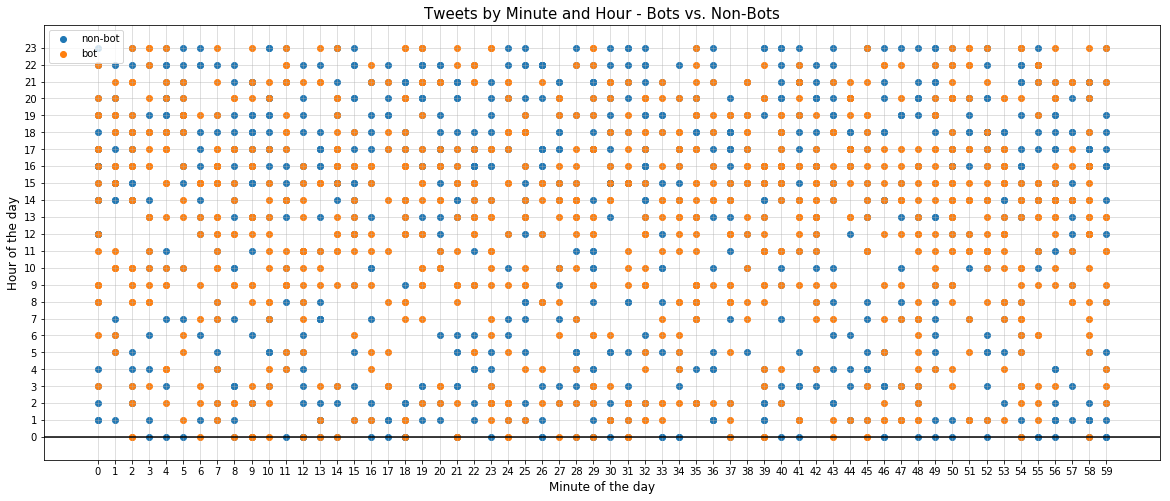

In [11]:
#Plot 1000 random users to plot
def set_labels(ax):
    """
    This is just a 'helper funtion' used in this question to make
    creating lables a bit more neat.
    input:  ax on which to set labels
    """
    ax.set_title("Tweets by Minute and Hour - Bots vs. Non-Bots", fontsize=15)
    ax.set_xlabel('Minute of the day', fontsize=12) 
    ax.set_ylabel('Hour of the day', fontsize=12)
    #position_names = ['Winter', 'Spring', 'Summer', 'Fall']
    #plt.xticks(range(len(position_names)))
    ax.set_yticks(range(24))
    ax.set_xticks(range(60))
    #ax.set_xticklabels(position_names)
    #ax.set_yticklabels(('0%', '20%', '40%', '60%', '80%', '100%', ''))
    #plt.xlim(-.5,len(position_names)-.5)
    #ax.set_ylim(0,60)
    ax.grid('True', alpha=.5)
    ax.axhline(y=0,color='black')
    ax.legend()

    return()

# Create plot
fig, ax = plt.subplots(1,1, figsize=(20,8))

# Plot 100 random tweets for each type of user
for (gp, df) in tweet_df.groupby(['is_bot']):
    indexes=np.sort(np.random.choice(df.shape[0], size=1000, replace=False)) # Using sort to make plotting easier later
    ax.scatter(df.iloc[indexes]['minute'], df.iloc[indexes]['hour'], label = ("bot" if gp == 1 else "non-bot" ) )

set_labels(ax)

fig.savefig('plots/FinalProject-EDA1.pdf', bbox_inches='tight')

**Plot 2: Tweets NLP Analysis - Distribution of topics in tweet per type of user**

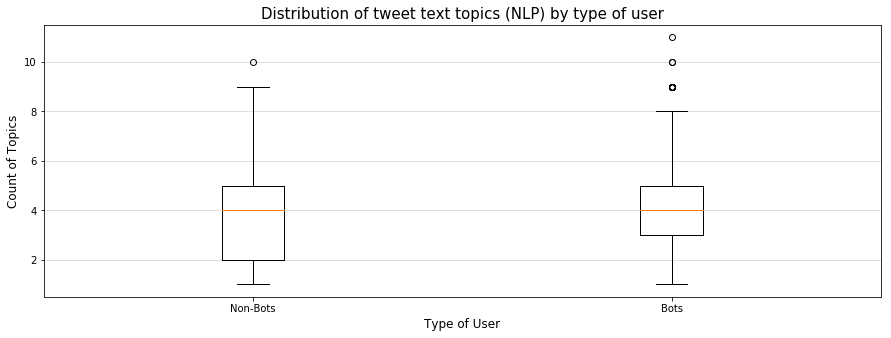

In [12]:
def set_labels(ax):
    """
    This is just a 'helper funtion' used in this question to make
    creating lables a bit more neat.
    input:  ax on which to set labels
    """
    ax.set_title("Distribution of tweet text topics (NLP) by type of user", fontsize=15)
    ax.set_xlabel("Type of User", fontsize=12)
    ax.set_ylabel("Count of Topics", fontsize=12)
    plt.xticks(range(len(position_names)))
    ax.set_xticklabels(["Non-Bots", "Bots"])
    plt.xlim(-.5,len(position_names)-.5)
    ax.grid('True', alpha=.5, axis='y')
    
    return()

position_names = []

# Create fix and ax
fig, ax = plt.subplots(figsize=(15,5))

for (gp, df) in tweet_df.groupby(['is_bot']):
    
    #indexes=np.sort(np.random.choice(df.shape[0], size=3000, replace=False)) # Using sort to make plotting easier later
    #counts = df.iloc[indexes]['nlp_count_key_phrases'].values

    ax.boxplot(df['nlp_count_key_phrases'], positions=[len(position_names)])
    
    position_names.append(gp)

set_labels(ax)

fig.savefig('plots/FinalProject-EDA2.pdf', bbox_inches='tight')

**Plot 3: Tweets NLP Analysis - Distribution of sentiment score per type of user**

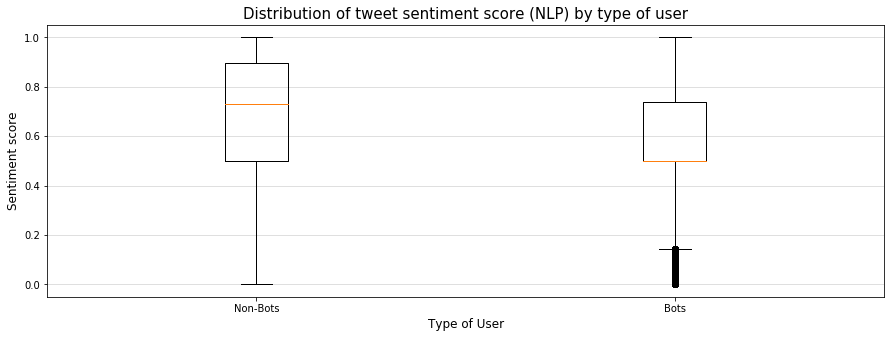

In [13]:
def set_labels(ax,position_names):
    """
    This is just a 'helper funtion' used in this question to make
    creating lables a bit more neat.
    input:  ax on which to set labels
    """
    ax.set_title("Distribution of tweet sentiment score (NLP) by type of user", fontsize=15)
    ax.set_xlabel("Type of User", fontsize=12)
    ax.set_ylabel("Sentiment score", fontsize=12)
    plt.xticks(range(len(position_names)))
    ax.set_xticklabels(["Non-Bots", "Bots"])
    plt.xlim(-.5,len(position_names)-.5)
    ax.grid('True', alpha=.5, axis='y')
    
    return()

position_names = []

# Create fix and ax
fig, ax = plt.subplots(figsize=(15,5))

for (gp, df) in tweet_df.groupby(['is_bot']):

    ax.boxplot(df['nlp_sentiment_score'], positions=[len(position_names)])
    
    position_names.append(gp)

set_labels(ax, position_names)

fig.savefig('plots/FinalProject-EDA3.pdf', bbox_inches='tight')

**Plot 4. Tweets by NLP Sentiment vs. NLP count of topics**

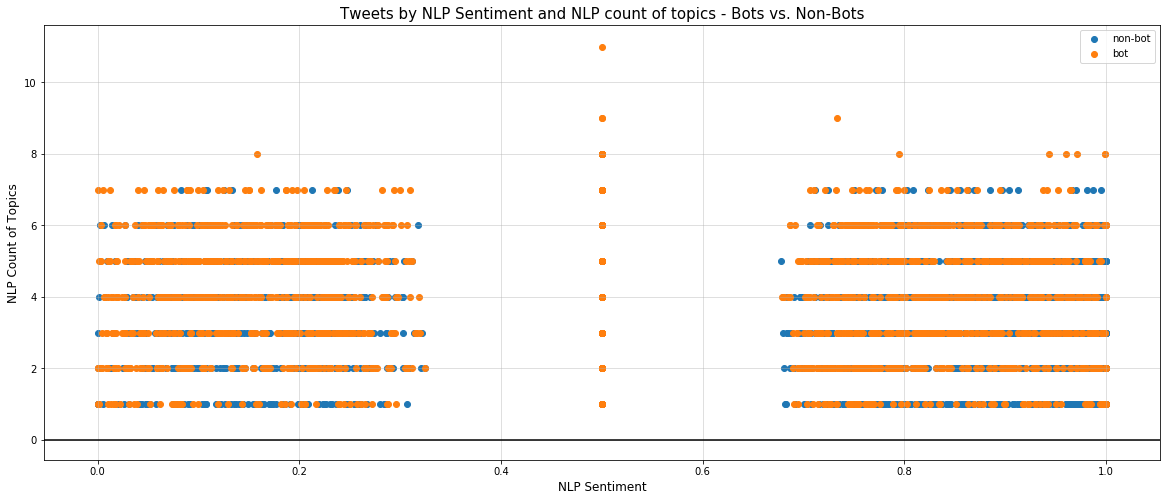

In [14]:
#Plot 1000 random users to plot
def set_labels(ax):
    """
    This is just a 'helper funtion' used in this question to make
    creating lables a bit more neat.
    input:  ax on which to set labels
    """
    ax.set_title("Tweets by NLP Sentiment and NLP count of topics - Bots vs. Non-Bots", fontsize=15)
    ax.set_xlabel('NLP Sentiment', fontsize=12) 
    ax.set_ylabel('NLP Count of Topics', fontsize=12)
    ax.grid('True', alpha=.5)
    ax.axhline(y=0,color='black')
    ax.legend()

    return()

# Create plot
fig, ax = plt.subplots(1,1, figsize=(20,8))

# Plot 100 random tweets for each type of user
for (gp, df) in tweet_df.groupby(['is_bot']):
    indexes=np.sort(np.random.choice(df.shape[0], size=3000, replace=False)) # Using sort to make plotting easier later
    ax.scatter(df.iloc[indexes]['nlp_sentiment_score'], df.iloc[indexes]['nlp_count_key_phrases'], label = ("bot" if gp == 1 else "non-bot" ))

set_labels(ax)

fig.savefig('plots/FinalProject-EDA4.pdf', bbox_inches='tight')

**Plot 5. Pearson correlation**

Text(0.5,1,'Pearson Correlation Coefficients - NLP Features')

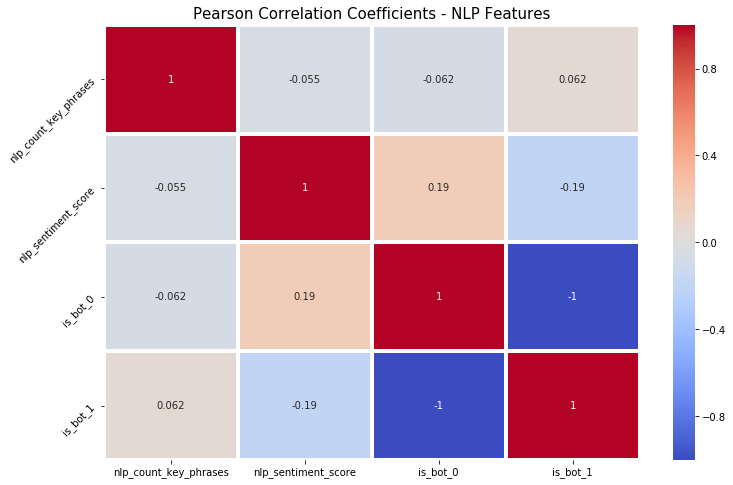

In [15]:
# plot heatmap using Seaborn
fig,ax = plt.subplots(figsize=(12,8))
    
indexes=np.sort(np.random.choice(tweet_df.shape[0], size=3000, replace=False)) # Using sort to make plotting easier later

df_plt = tweet_df.iloc[indexes][['is_bot', 'nlp_count_key_phrases', 'nlp_sentiment_score']]

df_plt = pd.get_dummies(df_plt, columns=['is_bot'])

# Calculate correlation matrix
cor_data = np.corrcoef(df_plt,rowvar=False)

# Use colnames below for labeling
col_names = df_plt.columns.values

sns.heatmap(cor_data,annot=True,cmap='coolwarm',linecolor='white',linewidth=3, ax=ax)

ax.set_xticklabels(col_names)
ax.set_yticklabels(col_names)

ocs, labels = plt.yticks()
plt.setp(labels, rotation=45)

plt.title('Pearson Correlation Coefficients - NLP Features',fontsize=15)

**Plot 6. Inter-tweet analysis - Bots vs. Non-bots**

In [16]:
tweet_df_grouped_user.describe()

,count_tweets,is_bot,nlp_count_key_phrases,nlp_sentiment_score,is_tweet,followers_count,avg_intertweet_time,avg_text_length
count,333.000000,333.000000,333.000000,333.000000,333.000000,3.140000e+02,333.000000,333.000000
mean,196.300300,0.312312,3.509506,0.588876,0.685976,4.379929e+06,538.054691,103.850547
std,591.874376,0.464134,0.843764,0.129740,0.322359,1.689820e+07,1841.073089,21.929151
min,0.000000,0.000000,1.000000,0.058283,0.000000,0.000000e+00,0.005139,23.000000
25%,29.000000,0.000000,3.000000,0.500000,0.530201,1.565000e+02,15.819306,91.929293
50%,99.000000,0.000000,3.564626,0.582509,0.777778,4.065000e+03,76.310194,107.250000
75%,139.000000,1.000000,4.081081,0.679489,0.959732,1.500345e+05,301.200620,118.563758
max,6807.000000,1.000000,5.600000,0.987318,1.000000,1.067185e+08,26665.765578,140.000000


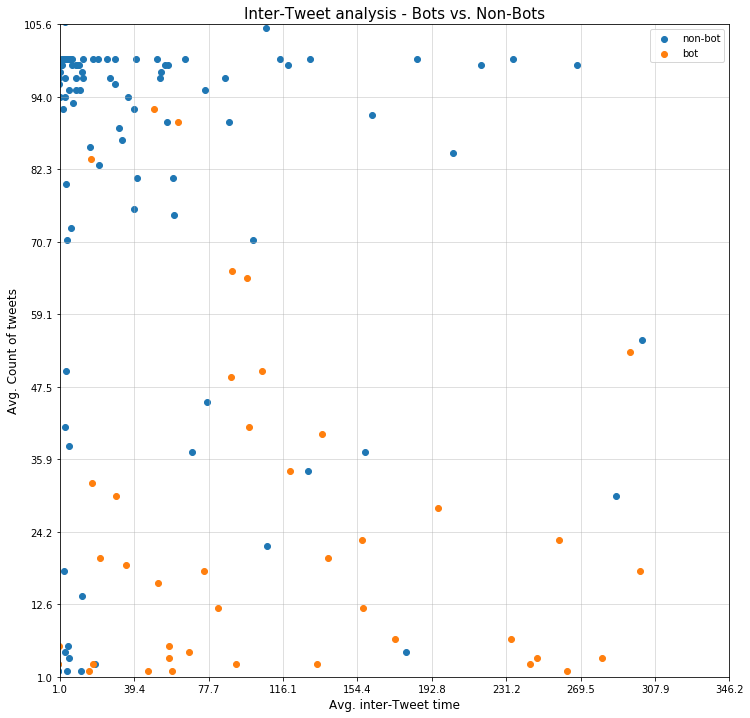

In [17]:
def remove_outliers (column_name : str, dataset : pd.Series, threshold : int = 2):
    """Algorithm to find the outliers  """  
    new_df = dataset.copy()
    
    new_df.reset_index(drop=True, inplace=True)
    
    column_check = new_df[column_name]
    
    mean = np.mean( column_check)
    
    stdev = np.std(column_check)
    
    outlier_indices = []
    
    for (index, value) in enumerate(column_check):
        distance_center =  np.abs((value - mean) / stdev)
        
        if(distance_center >= threshold):
            outlier_indices.append (index)
    
    return new_df.drop (new_df.index[outlier_indices])

#Plot 1000 random users to plot
def set_labels(ax, mean_x, mean_y):
    """
    This is just a 'helper funtion' used in this question to make
    creating lables a bit more neat.
    input:  ax on which to set labels
    """
    ax.set_title("Inter-Tweet analysis - Bots vs. Non-Bots", fontsize=15)
    ax.set_xlabel('Avg. inter-Tweet time', fontsize=12) 
    ax.set_ylabel('Avg. Count of tweets', fontsize=12)
    #Do the following to remove outlier from plot
    ax.set_xticks(np.linspace(1,mean_x, 10))
    ax.set_yticks(np.linspace(1,mean_y, 10))
    ax.set_xlim(1, mean_x)
    ax.set_ylim(1,mean_y)   
    ax.grid('True', alpha=.5)
    ax.axhline(y=0,color='black')
    ax.legend()

    return()

# Create plot
fig, ax = plt.subplots(1,1, figsize=(12,12))

# Remove outliers
df_plot = remove_outliers("avg_intertweet_time", tweet_df_grouped_user)
df_plot = remove_outliers("count_tweets", df_plot)

# Plot 100 random tweets for each type of user
for (gp, df) in df_plot.groupby('is_bot'):   
    ax.scatter(df["avg_intertweet_time"], df["count_tweets"], label = ("bot" if gp == 1 else "non-bot" ))

set_labels(ax, np.mean(df_plot["avg_intertweet_time"]), np.mean(df_plot["count_tweets"]))

fig.savefig('plots/FinalProject-EDA6.pdf', bbox_inches='tight')

### 3.4. Initial  Models (Milestone 3)

** Initial Model: Model with the following predictors: nlp_count_key_phrases', nlp_sentiment_score, is_tweet **

Note: below is the model used on Milestone 3, which used Tweets. From now on, all the modelling will be done based on data grouped by user.

In [18]:
def misclassification_rate(y_true, y_hat):
    
    n_obs = len(y_hat)
    error_count = 0
    for i in range(n_obs):
        if (y_hat[i] < .5 and y_true[i] == 1):
            error_count = error_count + 1
        elif (y_hat[i] > .5 and y_true[i] == 0):
            error_count = error_count +1
        else:
            pass

    return (error_count/n_obs)


df_bots = tweet_df[tweet_df["is_bot"] == 1]
df_notbots = tweet_df[tweet_df["is_bot"] == 0]

indexes_bots =np.sort(np.random.choice(df_bots.shape[0], size=15000, replace=False)) # Using sort to make plotting easier later
indexes_nonbots =np.sort(np.random.choice(df_notbots.shape[0], size=15000, replace=False)) # Using sort to make plotting easier later

fit_df = pd.concat( [df_bots.iloc[indexes_bots],df_notbots.iloc[indexes_nonbots] ])

train_data, test_data = train_test_split(fit_df, test_size=.2, random_state=42, stratify=fit_df['is_bot'])

y_train = train_data['is_bot'].values
y_test = test_data['is_bot'].values


X_train = train_data[['nlp_count_key_phrases', 'nlp_sentiment_score', 'is_tweet']]
X_test = test_data[['nlp_count_key_phrases', 'nlp_sentiment_score', 'is_tweet']]

multi_logistic_fit = LogisticRegression(C=100000).fit(X_train,y_train)

y_train_hat = multi_logistic_fit.predict(X_train) 

missclassification_rate = misclassification_rate(y_train, y_train_hat)

classification_accuracy_train = 1 - missclassification_rate

y_test_hat = multi_logistic_fit.predict(X_test) 

missclassification_rate = misclassification_rate(y_train, y_test_hat)

classification_accuracy_test = 1 - missclassification_rate


print("Classification Rate - Training data: {0}".format(classification_accuracy_train))    
print("Classification Rate - Test data: {0}".format(classification_accuracy_test))

print(multi_logistic_fit.coef_)

Classification Rate - Training data: 0.6374583333333333
Classification Rate - Test data: 0.5055000000000001
[[ 0.07905443 -1.50266056  0.46651502]]


**Model using data grouped by user and following predictors: nlp_count_key_phrases', nlp_sentiment_score, is_tweet, count_tweets, avg_intertweet_time **

In [19]:
def misclassification_rate(y_true, y_hat):
    
    n_obs = len(y_hat)
    error_count = 0
    for i in range(n_obs):
        if (y_hat[i] < .5 and y_true[i] == 1):
            error_count = error_count + 1
        elif (y_hat[i] > .5 and y_true[i] == 0):
            error_count = error_count +1
        else:
            pass

    return (error_count/n_obs)

train_data, test_data = train_test_split(tweet_df_grouped_user, test_size=.2, random_state=42, stratify=tweet_df_grouped_user['is_bot'])

y_train = train_data['is_bot'].values
y_test = test_data['is_bot'].values

X_train = train_data[['nlp_count_key_phrases', 'nlp_sentiment_score', 'is_tweet', 'count_tweets', 'avg_intertweet_time', 'avg_text_length' ]]
X_test = test_data[['nlp_count_key_phrases', 'nlp_sentiment_score', 'is_tweet', 'count_tweets', 'avg_intertweet_time', 'avg_text_length']]


multi_logistic_fit = LogisticRegression(C=100000).fit(X_train,y_train)

y_train_hat = multi_logistic_fit.predict(X_train) 

missclassification_rate = misclassification_rate(y_train, y_train_hat)

classification_accuracy_train = 1 - missclassification_rate

y_test_hat = multi_logistic_fit.predict(X_test) 

missclassification_rate = misclassification_rate(y_train, y_test_hat)

classification_accuracy_test = 1 - missclassification_rate


print("Classification Rate - Training data: {0}".format(classification_accuracy_train))    
print("Classification Rate - Test data: {0}".format(classification_accuracy_test))

print(multi_logistic_fit.coef_)

Classification Rate - Training data: 0.8082706766917294
Classification Rate - Test data: 0.5522388059701493
[[ 9.25376831e-02 -1.22170049e+01 -1.25331850e+00  1.25802760e-03
   5.54260393e-05  9.17996974e-03]]


In [20]:
bot_mask = tweet_df_grouped_user['is_bot'] == 1
bot_tweets = tweet_df_grouped_user[bot_mask]
bot_names = bot_tweets['screen_name'].unique()
print(f'Shape of bot names dataframe {bot_names.shape}.')
print(f'Shape of bot tweet dataframe {bot_tweets.shape}.')
print()

# Here are verifieds and their tweets
verified_mask = tweet_df_grouped_user['is_bot'] == 0
verified_tweets =tweet_df_grouped_user[verified_mask]
verified_names = verified_tweets['screen_name'].unique()
print(f'Shape of verified names dataframe {verified_names.shape}.')
print(f'Shape of verified tweet dataframe {verified_tweets.shape}.')
print()

Shape of bot names dataframe (104,).
Shape of bot tweet dataframe (104, 9).

Shape of verified names dataframe (229,).
Shape of verified tweet dataframe (229, 9).



## 3.4. Split Train and Test, and save to file for modeling

The files generated by the code below will be used for modeling using ensemble methods and Neural Networks. 

In [21]:
train_data, test_data = train_test_split(tweet_df_grouped_user, test_size=.5, random_state=42, stratify=tweet_df_grouped_user['is_bot'])

In [22]:
train_json = train_data.to_json(orient='records')
test_json = test_data.to_json(orient='records')

with open('data/train_data.json', 'w') as outfile:  
    json.dump(train_json, outfile)
    
with open('data/test_data.json', 'w') as outfile:  
    json.dump(test_json, outfile)
    
with open("data/train_data.json") as datafile:
    data = json.load(datafile)

train_data = pd.read_json(data)

with open("data/test_data.json") as datafile:
    data = json.load(datafile)

test_data = pd.read_json(data)

print(train_data.shape)
print(train_data.dtypes)
print()
print()

print(test_data.shape)
print(test_data.dtypes)
print()
print()

bot_mask = train_data['is_bot'] == 0
bot_tweets = train_data[bot_mask]
bot_names = bot_tweets['screen_name'].unique()
print(f'Shape of train bot names dataframe {bot_names.shape}.')
print(f'Shape of train bot tweet dataframe {bot_tweets.shape}.')
print()

# Here are verifieds and their tweets
verified_mask = train_data['is_bot'] == 1
verified_tweets = train_data[verified_mask]
verified_names = verified_tweets['screen_name'].unique()
print(f'Shape of train verified names dataframe {verified_names.shape}.')
print(f'Shape of train verified tweet dataframe {verified_tweets.shape}.')
print()

bot_mask = test_data['is_bot'] == 0
bot_tweets = test_data[bot_mask]
bot_names = bot_tweets['screen_name'].unique()
print(f'Shape of test bot names dataframe {bot_names.shape}.')
print(f'Shape of test bot tweet dataframe {bot_tweets.shape}.')
print()

# Here are verifieds and their tweets
verified_mask = test_data['is_bot'] == 1
verified_tweets = test_data[verified_mask]
verified_names = verified_tweets['screen_name'].unique()
print(f'Shape of test verified names dataframe {verified_names.shape}.')
print(f'Shape of test verified tweet dataframe {verified_tweets.shape}.')
print()

(166, 9)
avg_intertweet_time      float64
avg_text_length          float64
count_tweets               int64
followers_count          float64
is_bot                     int64
is_tweet                 float64
nlp_count_key_phrases    float64
nlp_sentiment_score      float64
screen_name               object
dtype: object


(167, 9)
avg_intertweet_time      float64
avg_text_length          float64
count_tweets               int64
followers_count          float64
is_bot                     int64
is_tweet                 float64
nlp_count_key_phrases    float64
nlp_sentiment_score      float64
screen_name               object
dtype: object


Shape of train bot names dataframe (114,).
Shape of train bot tweet dataframe (114, 9).

Shape of train verified names dataframe (52,).
Shape of train verified tweet dataframe (52, 9).

Shape of test bot names dataframe (115,).
Shape of test bot tweet dataframe (115, 9).

Shape of test verified names dataframe (52,).
Shape of test verified tweet datafram

**CALL WITH QUESTIONS: Mark: 727-410-8836 | Eumar: 954-918-4874**